## Import Required Libraries

In [1]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline
from pyspark.sql.functions import *
from pyspark.sql.functions import col, avg, count, corr, month, year, to_timestamp
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, TimestampType, StringType, DoubleType, IntegerType

## Define Schema and Import Data From Dataset

In [2]:
%%capture --no-stderr

# Create a Spark session
spark = SparkSession.builder.appName("FraudDetection").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# Define the schema
custom_schema = StructType([
    StructField("Timestamp", StringType(), nullable=True),
    StructField("FromBank", IntegerType(), nullable=True),
    StructField("FromAccount", StringType(), nullable=True),
    StructField("ToBank", IntegerType(), nullable=True),
    StructField("ToAccount", StringType(), nullable=True),
    StructField("AmountReceived", DoubleType(), nullable=True),
    StructField("ReceivingCurrency", StringType(), nullable=True),
    StructField("AmountPaid", DoubleType(), nullable=True),
    StructField("PaymentCurrency", StringType(), nullable=True),
    StructField("PaymentFormat", StringType(), nullable=True),
    StructField("IsLaundering", IntegerType(), nullable=True)
])

# Load the CSV file into a DataFrame with the specified schema
file_path = "HI-Small_Trans.csv"
df = spark.read.csv(file_path, header=True, schema=custom_schema)

# Register the DataFrame as a temporary SQL table
df.createOrReplaceTempView("transactions")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/09 21:24:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/09 21:24:08 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Data Extraction

### Schema of the Dataset Imported

In [3]:
df.printSchema()

root
 |-- Timestamp: string (nullable = true)
 |-- FromBank: integer (nullable = true)
 |-- FromAccount: string (nullable = true)
 |-- ToBank: integer (nullable = true)
 |-- ToAccount: string (nullable = true)
 |-- AmountReceived: double (nullable = true)
 |-- ReceivingCurrency: string (nullable = true)
 |-- AmountPaid: double (nullable = true)
 |-- PaymentCurrency: string (nullable = true)
 |-- PaymentFormat: string (nullable = true)
 |-- IsLaundering: integer (nullable = true)



### Convert string data in 'Timestamp' column to timestamp datatype

In [4]:
from pyspark.sql.functions import to_timestamp

# Assuming "timestamp_str" is the column containing the timestamp string
df = df.withColumn("Timestamp", to_timestamp("Timestamp", "yyyy/MM/dd HH:mm"))

# Show the DataFrame schema with the new timestamp column
df.printSchema()

root
 |-- Timestamp: timestamp (nullable = true)
 |-- FromBank: integer (nullable = true)
 |-- FromAccount: string (nullable = true)
 |-- ToBank: integer (nullable = true)
 |-- ToAccount: string (nullable = true)
 |-- AmountReceived: double (nullable = true)
 |-- ReceivingCurrency: string (nullable = true)
 |-- AmountPaid: double (nullable = true)
 |-- PaymentCurrency: string (nullable = true)
 |-- PaymentFormat: string (nullable = true)
 |-- IsLaundering: integer (nullable = true)



### View the data in tabular format

In [5]:
import warnings
warnings.filterwarnings('ignore')

df.show(3)

+-------------------+--------+-----------+------+---------+--------------+-----------------+----------+---------------+-------------+------------+
|          Timestamp|FromBank|FromAccount|ToBank|ToAccount|AmountReceived|ReceivingCurrency|AmountPaid|PaymentCurrency|PaymentFormat|IsLaundering|
+-------------------+--------+-----------+------+---------+--------------+-----------------+----------+---------------+-------------+------------+
|2022-09-01 00:20:00|      10|  8000EBD30|    10|8000EBD30|       3697.34|        US Dollar|   3697.34|      US Dollar| Reinvestment|           0|
|2022-09-01 00:20:00|    3208|  8000F4580|     1|8000F5340|          0.01|        US Dollar|      0.01|      US Dollar|       Cheque|           0|
|2022-09-01 00:00:00|    3209|  8000F4670|  3209|8000F4670|      14675.57|        US Dollar|  14675.57|      US Dollar| Reinvestment|           0|
+-------------------+--------+-----------+------+---------+--------------+-----------------+----------+---------------

### No of records present in the dataframe

In [6]:
df.count()

5078345

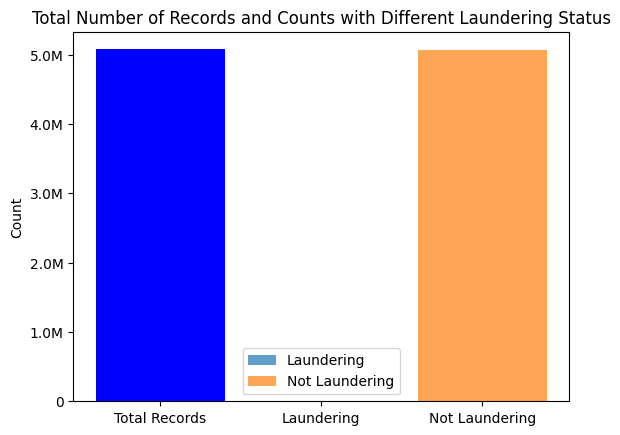

In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Assuming df is your DataFrame

# Calculate the total count of records
total_records = df.count()

# Calculate the count of transactions with different laundering statuses
laundering_counts = df.groupBy("IsLaundering").count().collect()

# Plot the total count and counts for different laundering statuses using Matplotlib
fig, ax = plt.subplots()

# Plot for total records
ax.bar(['Total Records'], [total_records], color='blue')

# Plot for counts with different laundering statuses
for row in laundering_counts:
    status, count = row['IsLaundering'], row['count']
    status_label = 'Not Laundering' if status == 0 else 'Laundering'
    ax.bar([f'{status_label}'], [count], label=f'{status_label}', alpha=0.7)

# Customize the plot as needed
ax.set_title('Total Number of Records and Counts with Different Laundering Status')
ax.set_ylabel('Count')
ax.legend()

# Format the y-axis ticks with proper steps (e.g., in millions)
def format_ticks(value, pos):
    if value < 1e6:
        return f'{int(value):,}'
    else:
        return f'{value / 1e6:.1f}M'

ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

# Show the plot
plt.show()


### It looks like there is no record corresponding to positive laundering cases in the dataset because the number of positive money laundering cases is relatively much lower 

In [8]:
# Print the number of laundering cases
num_laundering_cases = next((row['count'] for row in laundering_counts if row['IsLaundering'] == 1), 0)
print(f"Number of Laundering Cases: {num_laundering_cases}")

Number of Laundering Cases: 5177


In [9]:
# Print the number of laundering cases
num_non_laundering_cases = next((row['count'] for row in laundering_counts if row['IsLaundering'] == 0), 0)
print(f"Number of Non Laundering Cases: {num_non_laundering_cases}")


Number of Non Laundering Cases: 5073168


### Check for NULL Values in Every Column

In [10]:
from pyspark.sql.functions import col

# Assuming df is your Spark DataFrame
# Define the list of columns
columns_to_check = df.columns

# Create a list to store the results
null_counts = []

# Check for null values and collect results
for col_name in columns_to_check:
    null_count = df.filter(col(col_name).isNull()).count()
    null_counts.append((col_name, null_count))

# Convert the results to a Pandas DataFrame
null_counts_df = pd.DataFrame(null_counts, columns=['Column', 'NullCount'])

# Display the Pandas DataFrame
print(null_counts_df)


               Column  NullCount
0           Timestamp          0
1            FromBank          0
2         FromAccount          0
3              ToBank          0
4           ToAccount          0
5      AmountReceived          0
6   ReceivingCurrency          0
7          AmountPaid          0
8     PaymentCurrency          0
9       PaymentFormat          0
10       IsLaundering          0


### Check for DUPLICATE Records

### Count and Drop Missing Values: Because there are no cilumns with NULL/Missing Value, we need not perform this step

In [11]:
# Assuming df is your DataFrame
duplicate_count = df.count() - df.dropDuplicates().count()

if duplicate_count == 0:
    print("No duplicate records found.")
else:
    print(f"Found {duplicate_count} duplicate records.")

Found 9 duplicate records.


### Show all DUPLICATE Records

In [12]:
# Assuming df is your DataFrame
duplicate_records = df.groupBy(df.columns).count().filter("count > 1")

if duplicate_records.count() == 0:
    print("No duplicate records found.")
else:
    print("Duplicate records:")
    duplicate_records.show(truncate=False)

Duplicate records:


+-------------------+--------+-----------+------+---------+--------------+-----------------+----------+---------------+-------------+------------+-----+
|Timestamp          |FromBank|FromAccount|ToBank|ToAccount|AmountReceived|ReceivingCurrency|AmountPaid|PaymentCurrency|PaymentFormat|IsLaundering|count|
+-------------------+--------+-----------+------+---------+--------------+-----------------+----------+---------------+-------------+------------+-----+
|2022-09-07 21:25:00|29992   |8099A29B1  |220   |813725AE1|3.0E-6        |Bitcoin          |3.0E-6    |Bitcoin        |Bitcoin      |0           |2    |
|2022-09-09 10:03:00|6075    |80C702911  |6075  |80C702910|2.0E-6        |Bitcoin          |0.02      |US Dollar      |ACH          |0           |2    |
|2022-09-08 21:05:00|113779  |811144AB1  |53744 |813C777F1|2.0E-6        |Bitcoin          |2.0E-6    |Bitcoin        |Bitcoin      |0           |2    |
|2022-09-08 21:05:00|113779  |811144AB1  |113779|811144AB0|2.0E-6        |Bitcoin 

### Drop Duplicates

In [13]:
# Assuming df is your DataFrame
df = df.dropDuplicates()

# Show the result
df.count()

5078336

### Amount is received in how many currencies?

In [14]:
# Assuming df is your Spark DataFrame
received_currencies_df = df.groupBy("ReceivingCurrency").count()

# Display the DataFrame of distinct currencies
received_currencies_df.show(truncate=False)

# Display the DataFrame of distinct currencies
print(f"No of currencies the amount is received in: {received_currencies_df.count()}")


+-----------------+-------+
|ReceivingCurrency|count  |
+-----------------+-------+
|Yen              |156319 |
|UK Pound         |181255 |
|Australian Dollar|138511 |
|Saudi Riyal      |89971  |
|Mexican Peso     |111030 |
|Shekel           |194988 |
|Yuan             |206551 |
|Canadian Dollar  |141357 |
|Euro             |1172017|
|Rupee            |192065 |
|Swiss Franc      |237884 |
|US Dollar        |1879341|
|Brazil Real      |71544  |
|Bitcoin          |148142 |
|Ruble            |157361 |
+-----------------+-------+



No of currencies the amount is received in: 15


### Amount is paid in how many currencies?

In [15]:
# Assuming df is your Spark DataFrame
paid_currencies_df = df.groupBy("PaymentCurrency").count()

# Display the DataFrame of distinct currencies
paid_currencies_df.show(truncate=False)

# Display the DataFrame of distinct currencies
print(f"No of currencies the amount is paid in: {paid_currencies_df.count()}")

+-----------------+-------+
|PaymentCurrency  |count  |
+-----------------+-------+
|Yen              |155209 |
|UK Pound         |180738 |
|Australian Dollar|136769 |
|Saudi Riyal      |89014  |
|Mexican Peso     |110159 |
|Shekel           |192184 |
|Yuan             |213752 |
|Canadian Dollar  |140042 |
|Euro             |1168296|
|Rupee            |190202 |
|Swiss Franc      |234860 |
|US Dollar        |1895169|
|Brazil Real      |70703  |
|Bitcoin          |146061 |
|Ruble            |155178 |
+-----------------+-------+



No of currencies the amount is paid in: 15


### Plot to show count of transactions in each currency for both - amount received and paid

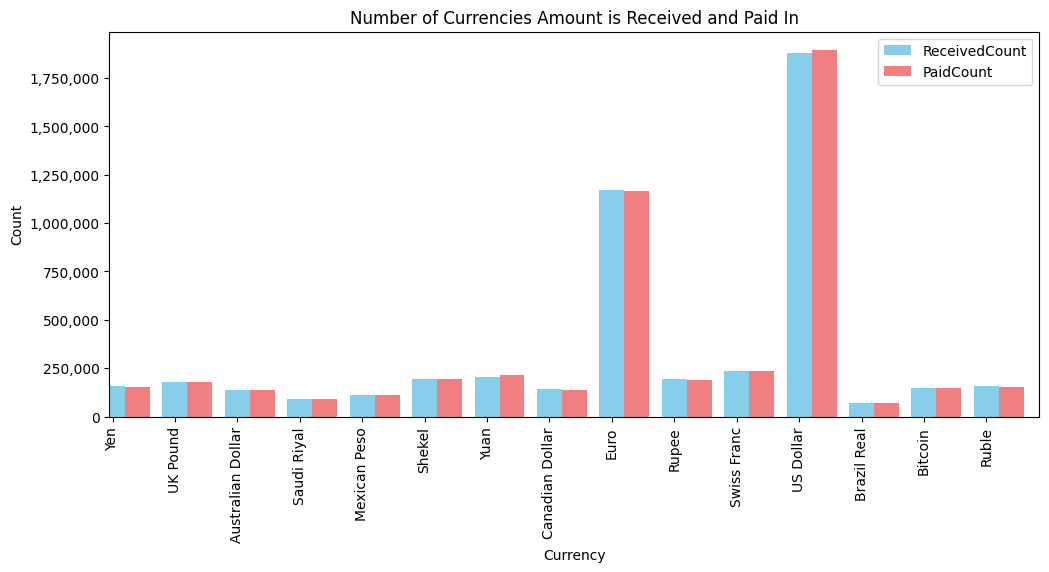

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

# Assuming df is your Spark DataFrame
# Code 1
received_currencies_df = df.groupBy("ReceivingCurrency").count()

# Code 2
paid_currencies_df = df.groupBy("PaymentCurrency").count()

# Convert to Pandas DataFrames
received_currencies_pd = received_currencies_df.toPandas()
paid_currencies_pd = paid_currencies_df.toPandas()

# Plotting
fig, ax = plt.subplots(figsize=(12, 5))

# Plot for "ReceivingCurrency"
received_currencies_pd.plot(kind='bar', x='ReceivingCurrency', y='count', ax=ax, color='skyblue', position=0.5, width=0.4, label='ReceivedCount')

# Plot for "PaymentCurrency"
paid_currencies_pd.plot(kind='bar', x='PaymentCurrency', y='count', ax=ax, color='lightcoral', position=-0.5, width=0.4, label='PaidCount')

ax.set_title("Number of Currencies Amount is Received and Paid In")
ax.set_xlabel("Currency")
ax.set_ylabel("Count")
ax.legend()

# Customize y-axis ticks in steps of thousands
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

plt.show()


### Create Dataframe with currencies converted to USD

In [17]:
import pandas as pd

# Define the exchange rates data
exchange_rates_data = [
    {"Currency": "Yen", "ExchangeRateToUSD": 0.0069},
    {"Currency": "UK Pound", "ExchangeRateToUSD": 1.234},
    {"Currency": "Australian Dollar", "ExchangeRateToUSD": 0.704},
    {"Currency": "Saudi Riyal", "ExchangeRateToUSD": 0.267},
    {"Currency": "Mexican Peso", "ExchangeRateToUSD": 0.050},
    {"Currency": "Shekel", "ExchangeRateToUSD": 0.300},
    {"Currency": "Yuan", "ExchangeRateToUSD": 0.147},
    {"Currency": "Canadian Dollar", "ExchangeRateToUSD": 0.754},
    {"Currency": "Euro", "ExchangeRateToUSD": 1.045},
    {"Currency": "Rupee", "ExchangeRateToUSD": 0.012},
    {"Currency": "Swiss Franc", "ExchangeRateToUSD": 1.028},
    {"Currency": "US Dollar", "ExchangeRateToUSD": 1.0},
    {"Currency": "Brazil Real", "ExchangeRateToUSD": 0.191},
    {"Currency": "Bitcoin", "ExchangeRateToUSD": 16386},
    {"Currency": "Ruble", "ExchangeRateToUSD": 0.013},
]

# Create the exchange_rates_df DataFrame in Pandas
exchange_rates_df = pd.DataFrame(exchange_rates_data)

# Display the Pandas DataFrame
print(exchange_rates_df)

             Currency  ExchangeRateToUSD
0                 Yen             0.0069
1            UK Pound             1.2340
2   Australian Dollar             0.7040
3         Saudi Riyal             0.2670
4        Mexican Peso             0.0500
5              Shekel             0.3000
6                Yuan             0.1470
7     Canadian Dollar             0.7540
8                Euro             1.0450
9               Rupee             0.0120
10        Swiss Franc             1.0280
11          US Dollar             1.0000
12        Brazil Real             0.1910
13            Bitcoin         16386.0000
14              Ruble             0.0130


In [18]:
exchange_rates_df = spark.createDataFrame(exchange_rates_df)

# Show the PySpark DataFrame
exchange_rates_df.show()

+-----------------+-----------------+
|         Currency|ExchangeRateToUSD|
+-----------------+-----------------+
|              Yen|           0.0069|
|         UK Pound|            1.234|
|Australian Dollar|            0.704|
|      Saudi Riyal|            0.267|
|     Mexican Peso|             0.05|
|           Shekel|              0.3|
|             Yuan|            0.147|
|  Canadian Dollar|            0.754|
|             Euro|            1.045|
|            Rupee|            0.012|
|      Swiss Franc|            1.028|
|        US Dollar|              1.0|
|      Brazil Real|            0.191|
|          Bitcoin|          16386.0|
|            Ruble|            0.013|
+-----------------+-----------------+



In [19]:
from pyspark.sql.functions import col

# Assuming df is your original DataFrame
# Assuming exchange_rates_df is another DataFrame with columns Currency, ExchangeRateToUSD

# Join the original DataFrame with exchange rates DataFrame for ReceivingCurrency
df_with_receiving_rate = df.join(
    exchange_rates_df.withColumnRenamed("Currency", "RecCurrency") \
                    .withColumnRenamed("ExchangeRateToUSD", "ReceivingExchangeRate"),
    col("RecCurrency") == col("ReceivingCurrency")  # Assuming the original column name in df is ReceivingCurrencyOriginal
)

# Join the resulting DataFrame with exchange rates DataFrame for PaymentCurrency
df_with_rates = df_with_receiving_rate.join(
    exchange_rates_df.withColumnRenamed("Currency", "PayCurrency") \
                    .withColumnRenamed("ExchangeRateToUSD", "PaymentExchangeRate"),
    col("PayCurrency") == col("PaymentCurrency")  # Assuming the original column name in df is PaymentCurrencyOriginal
)

# Convert AmountReceived and AmountPaid to USD based on exchange rates
currency_converted_df = df_with_rates.withColumn("AmountReceivedUSD", col("AmountReceived") * col("ReceivingExchangeRate"))
currency_converted_df = currency_converted_df.withColumn("AmountPaidUSD", col("AmountPaid") * col("PaymentExchangeRate"))

# Select the relevant columns
currency_converted_df = currency_converted_df.select("Timestamp", "FromBank", "FromAccount", "ToBank", "ToAccount",
                                                     "AmountReceived", "ReceivingCurrency", "AmountReceivedUSD",
                                                     "AmountPaid", "PaymentCurrency", "AmountPaidUSD",
                                                     "PaymentFormat", "IsLaundering")

# Show the resulting DataFrame
currency_converted_df.show()


+-------------------+--------+-----------+------+---------+--------------+-----------------+------------------+----------+-----------------+------------------+-------------+------------+
|          Timestamp|FromBank|FromAccount|ToBank|ToAccount|AmountReceived|ReceivingCurrency| AmountReceivedUSD|AmountPaid|  PaymentCurrency|     AmountPaidUSD|PaymentFormat|IsLaundering|
+-------------------+--------+-----------+------+---------+--------------+-----------------+------------------+----------+-----------------+------------------+-------------+------------+
|2022-09-01 01:09:00|      70|  1004288A0|     6|80A1E4F60|        432.98|Australian Dollar|         304.81792|    432.98|Australian Dollar|         304.81792|       Cheque|           0|
|2022-09-01 00:10:00|       6|  80A0EC1B0|     6|80A0EC1B0|     120101.05|Australian Dollar| 84551.13919999999| 120101.05|Australian Dollar| 84551.13919999999| Reinvestment|           0|
|2022-09-01 21:22:00|       6|  80A104BE0|     6|80A102BB0|      

In [21]:
currency_converted_df.write.csv("PreprocessedDataset", header=True, mode="overwrite")

23/12/09 21:58:41 ERROR Utils: Aborting task                        (0 + 2) / 4]
com.univocity.parsers.common.TextWritingException: Error writing row.
Internal state when error was thrown: recordCount=289646, recordData=[2022-09-02T23:15:00.000-04:00, 317990, 80687D240, 17854, 80682F2E0, 34.71, Euro, 36.27195, 34.71, Euro, 36.27195, ACH, 0]
	at com.univocity.parsers.common.AbstractWriter.throwExceptionAndClose(AbstractWriter.java:1055)
	at com.univocity.parsers.common.AbstractWriter.writeRow(AbstractWriter.java:834)
	at org.apache.spark.sql.catalyst.csv.UnivocityGenerator.write(UnivocityGenerator.scala:117)
	at org.apache.spark.sql.execution.datasources.csv.CsvOutputWriter.write(CsvOutputWriter.scala:46)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.write(FileFormatDataWriter.scala:175)
	at org.apache.spark.sql.execution.datasources.FileFormatDataWriter.writeWithMetrics(FileFormatDataWriter.scala:85)
	at org.apache.spark.sql.execution.datasources.FileFormatDa

Py4JJavaError: An error occurred while calling o198.csv.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 137.0 failed 1 times, most recent failure: Lost task 0.0 in stage 137.0 (TID 207) (jupyter-sv2564 executor driver): org.apache.spark.SparkException: [TASK_WRITE_FAILED] Task failed while writing rows to file:/home/jovyan/PreprocessedDataset.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.taskFailedWhileWritingRowsError(QueryExecutionErrors.scala:774)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:420)
	at org.apache.spark.sql.execution.datasources.WriteFilesExec.$anonfun$doExecuteWrite$1(WriteFiles.scala:100)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: com.univocity.parsers.common.TextWritingException: Error writing row.
Internal state when error was thrown: recordCount=318733, recordData=[2022-09-05T23:42:00.000-04:00, 33739, 80C9DEA10, 34523, 80CDD5980, 60148.43, Mexican Peso, 3007.4215000000004, 60148.43, Mexican Peso, 3007.4215000000004, Credit Card, 0]
	at com.univocity.parsers.common.AbstractWriter.throwExceptionAndClose(AbstractWriter.java:1055)
	at com.univocity.parsers.common.AbstractWriter.writeRow(AbstractWriter.java:834)
	at org.apache.spark.sql.catalyst.csv.UnivocityGenerator.write(UnivocityGenerator.scala:117)
	at org.apache.spark.sql.execution.datasources.csv.CsvOutputWriter.write(CsvOutputWriter.scala:46)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.write(FileFormatDataWriter.scala:175)
	at org.apache.spark.sql.execution.datasources.FileFormatDataWriter.writeWithMetrics(FileFormatDataWriter.scala:85)
	at org.apache.spark.sql.execution.datasources.FileFormatDataWriter.writeWithIterator(FileFormatDataWriter.scala:92)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$executeTask$1(FileFormatWriter.scala:403)
	at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1397)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:410)
	... 17 more
Caused by: java.lang.IllegalStateException: Error closing the output.
	at com.univocity.parsers.common.AbstractWriter.close(AbstractWriter.java:1000)
	at com.univocity.parsers.common.AbstractWriter.throwExceptionAndClose(AbstractWriter.java:1042)
	at com.univocity.parsers.common.AbstractWriter.internalWriteRow(AbstractWriter.java:949)
	at com.univocity.parsers.common.AbstractWriter.writeRow(AbstractWriter.java:832)
	... 25 more
Caused by: org.apache.hadoop.fs.FSError: java.io.IOException: No space left on device
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileOutputStream.write(RawLocalFileSystem.java:349)
	at java.base/java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:125)
	at java.base/java.io.BufferedOutputStream.implWrite(BufferedOutputStream.java:222)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:206)
	at org.apache.hadoop.fs.FSDataOutputStream$PositionCache.write(FSDataOutputStream.java:62)
	at java.base/java.io.DataOutputStream.write(DataOutputStream.java:115)
	at org.apache.hadoop.fs.ChecksumFileSystem$ChecksumFSOutputSummer.writeChunk(ChecksumFileSystem.java:459)
	at org.apache.hadoop.fs.FSOutputSummer.writeChecksumChunks(FSOutputSummer.java:218)
	at org.apache.hadoop.fs.FSOutputSummer.flushBuffer(FSOutputSummer.java:165)
	at org.apache.hadoop.fs.FSOutputSummer.flushBuffer(FSOutputSummer.java:146)
	at org.apache.hadoop.fs.ChecksumFileSystem$ChecksumFSOutputSummer.close(ChecksumFileSystem.java:447)
	at org.apache.hadoop.fs.FSDataOutputStream$PositionCache.close(FSDataOutputStream.java:77)
	at org.apache.hadoop.fs.FSDataOutputStream.close(FSDataOutputStream.java:106)
	at java.base/sun.nio.cs.StreamEncoder.implClose(StreamEncoder.java:439)
	at java.base/sun.nio.cs.StreamEncoder.lockedClose(StreamEncoder.java:237)
	at java.base/sun.nio.cs.StreamEncoder.close(StreamEncoder.java:222)
	at java.base/java.io.OutputStreamWriter.close(OutputStreamWriter.java:266)
	at com.univocity.parsers.common.AbstractWriter.close(AbstractWriter.java:996)
	... 28 more
Caused by: java.io.IOException: No space left on device
	at java.base/java.io.FileOutputStream.writeBytes(Native Method)
	at java.base/java.io.FileOutputStream.write(FileOutputStream.java:367)
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileOutputStream.write(RawLocalFileSystem.java:345)
	... 45 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$executeWrite$4(FileFormatWriter.scala:307)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.writeAndCommit(FileFormatWriter.scala:271)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeWrite(FileFormatWriter.scala:304)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:190)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:190)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:113)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:111)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:125)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:374)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:402)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:374)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:437)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:85)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:83)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:142)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:859)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:388)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:361)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:240)
	at org.apache.spark.sql.DataFrameWriter.csv(DataFrameWriter.scala:850)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: org.apache.spark.SparkException: [TASK_WRITE_FAILED] Task failed while writing rows to file:/home/jovyan/PreprocessedDataset.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.taskFailedWhileWritingRowsError(QueryExecutionErrors.scala:774)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:420)
	at org.apache.spark.sql.execution.datasources.WriteFilesExec.$anonfun$doExecuteWrite$1(WriteFiles.scala:100)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: com.univocity.parsers.common.TextWritingException: Error writing row.
Internal state when error was thrown: recordCount=318733, recordData=[2022-09-05T23:42:00.000-04:00, 33739, 80C9DEA10, 34523, 80CDD5980, 60148.43, Mexican Peso, 3007.4215000000004, 60148.43, Mexican Peso, 3007.4215000000004, Credit Card, 0]
	at com.univocity.parsers.common.AbstractWriter.throwExceptionAndClose(AbstractWriter.java:1055)
	at com.univocity.parsers.common.AbstractWriter.writeRow(AbstractWriter.java:834)
	at org.apache.spark.sql.catalyst.csv.UnivocityGenerator.write(UnivocityGenerator.scala:117)
	at org.apache.spark.sql.execution.datasources.csv.CsvOutputWriter.write(CsvOutputWriter.scala:46)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.write(FileFormatDataWriter.scala:175)
	at org.apache.spark.sql.execution.datasources.FileFormatDataWriter.writeWithMetrics(FileFormatDataWriter.scala:85)
	at org.apache.spark.sql.execution.datasources.FileFormatDataWriter.writeWithIterator(FileFormatDataWriter.scala:92)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$executeTask$1(FileFormatWriter.scala:403)
	at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1397)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:410)
	... 17 more
Caused by: java.lang.IllegalStateException: Error closing the output.
	at com.univocity.parsers.common.AbstractWriter.close(AbstractWriter.java:1000)
	at com.univocity.parsers.common.AbstractWriter.throwExceptionAndClose(AbstractWriter.java:1042)
	at com.univocity.parsers.common.AbstractWriter.internalWriteRow(AbstractWriter.java:949)
	at com.univocity.parsers.common.AbstractWriter.writeRow(AbstractWriter.java:832)
	... 25 more
Caused by: org.apache.hadoop.fs.FSError: java.io.IOException: No space left on device
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileOutputStream.write(RawLocalFileSystem.java:349)
	at java.base/java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:125)
	at java.base/java.io.BufferedOutputStream.implWrite(BufferedOutputStream.java:222)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:206)
	at org.apache.hadoop.fs.FSDataOutputStream$PositionCache.write(FSDataOutputStream.java:62)
	at java.base/java.io.DataOutputStream.write(DataOutputStream.java:115)
	at org.apache.hadoop.fs.ChecksumFileSystem$ChecksumFSOutputSummer.writeChunk(ChecksumFileSystem.java:459)
	at org.apache.hadoop.fs.FSOutputSummer.writeChecksumChunks(FSOutputSummer.java:218)
	at org.apache.hadoop.fs.FSOutputSummer.flushBuffer(FSOutputSummer.java:165)
	at org.apache.hadoop.fs.FSOutputSummer.flushBuffer(FSOutputSummer.java:146)
	at org.apache.hadoop.fs.ChecksumFileSystem$ChecksumFSOutputSummer.close(ChecksumFileSystem.java:447)
	at org.apache.hadoop.fs.FSDataOutputStream$PositionCache.close(FSDataOutputStream.java:77)
	at org.apache.hadoop.fs.FSDataOutputStream.close(FSDataOutputStream.java:106)
	at java.base/sun.nio.cs.StreamEncoder.implClose(StreamEncoder.java:439)
	at java.base/sun.nio.cs.StreamEncoder.lockedClose(StreamEncoder.java:237)
	at java.base/sun.nio.cs.StreamEncoder.close(StreamEncoder.java:222)
	at java.base/java.io.OutputStreamWriter.close(OutputStreamWriter.java:266)
	at com.univocity.parsers.common.AbstractWriter.close(AbstractWriter.java:996)
	... 28 more
Caused by: java.io.IOException: No space left on device
	at java.base/java.io.FileOutputStream.writeBytes(Native Method)
	at java.base/java.io.FileOutputStream.write(FileOutputStream.java:367)
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileOutputStream.write(RawLocalFileSystem.java:345)
	... 45 more


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 41594)
Traceback (most recent call last):
  File "/opt/conda/envs/csgy-6513d-fall2023/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/envs/csgy-6513d-fall2023/lib/python3.9/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/envs/csgy-6513d-fall2023/lib/python3.9/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/envs/csgy-6513d-fall2023/lib/python3.9/socketserver.py", line 747, in __init__
    self.handle()
  File "/opt/conda/envs/csgy-6513d-fall2023/lib/python3.9/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/opt/conda/envs/csgy-6513d-fall2023/lib/python3.9/site-packages/pyspark/accumulators.py", line 267, in 

### Describe the amount received and paid in USD

In [20]:
# list of column names
columns = ["AmountReceivedUSD", "AmountPaidUSD"]

# Information for each column one at a time
for col_name in columns:
    print(f"Summary for column: {col_name}")
    currency_converted_df.describe(col_name).show()

Summary for column: AmountReceivedUSD


+-------+--------------------+
|summary|   AmountReceivedUSD|
+-------+--------------------+
|  count|             5078336|
|   mean|  339274.72974934615|
| stddev|2.3946118925802704E7|
|    min|              6.9E-5|
|    max|2.864297275461585...|
+-------+--------------------+

Summary for column: AmountPaidUSD


+-------+--------------------+
|summary|       AmountPaidUSD|
+-------+--------------------+
|  count|             5078336|
|   mean|    340290.148282013|
| stddev| 2.402091061721995E7|
|    min|              6.9E-5|
|    max|2.864297275461585...|
+-------+--------------------+



In [21]:
from pyspark.sql import functions as F

# Assuming currency_converted_df is your DataFrame
# Filter out rows with extreme values (e.g., Infinity or NaN)
filtered_df = currency_converted_df.filter(
    ~F.col("AmountPaidUSD").isin([float('inf'), float('-inf'), float('nan')])
)

# Use the agg function to calculate the maximum value directly
max_value = filtered_df.agg(F.max("AmountPaidUSD")).collect()[0][0]

# Convert the maximum value to millions
max_value_in_millions = max_value / 1_000_000

print("Maximum Value of AmountPaidUSD (in millions):", max_value_in_millions)


Maximum Value of AmountPaidUSD (in millions): 28642.972754615854


In [22]:
from pyspark.sql import functions as F

# Assuming currency_converted_df is your DataFrame
# Use the agg function to calculate the maximum value directly
max_value = currency_converted_df.agg(F.max("AmountPaidUSD")).collect()[0][0]

# Retrieve the row with the maximum value
row_with_max_value = currency_converted_df.filter(
    F.col("AmountPaidUSD") == max_value
).collect()

# Display the row with the maximum value
if row_with_max_value:
    print("Row with Maximum Value:")
    for column, value in zip(currency_converted_df.columns, row_with_max_value[0]):
        print(f"{column}: {value}")
else:
    print("No row found with the maximum value.")



Row with Maximum Value:
Timestamp: 2022-09-06 23:37:00
FromBank: 136334
FromAccount: 80D81A180
ToBank: 235551
ToAccount: 80D8816E0
AmountReceived: 149963208139.35
ReceivingCurrency: Brazil Real
AmountReceivedUSD: 28642972754.615852
AmountPaid: 149963208139.35
PaymentCurrency: Brazil Real
AmountPaidUSD: 28642972754.615852
PaymentFormat: ACH
IsLaundering: 0


## Data Exploration

### Check IsLaundering Class Distribution

   IsLaundering    count
0             1     5177
1             0  5073159


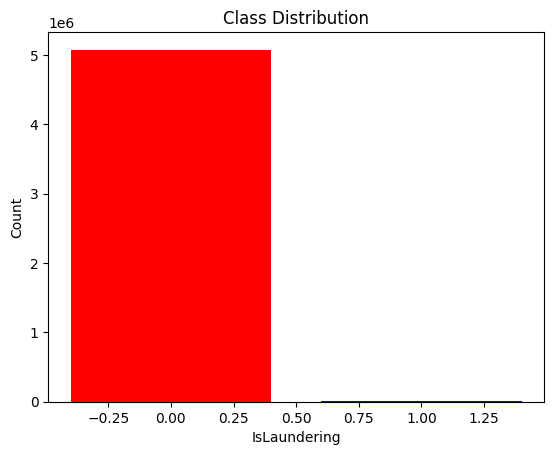

In [23]:
# Check the distribution of the target variable (IsLaundering)
class_distribution = df.groupBy("IsLaundering").count().toPandas()
print(class_distribution)

# Visualize the class distribution
plt.bar(class_distribution['IsLaundering'], class_distribution['count'], color=['blue', 'red'])
plt.xlabel('IsLaundering')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

### Correlation Analysis

In [24]:
from pyspark.ml.feature import VectorAssembler

# Assuming df is your DataFrame

# Define the columns you want to include in the correlation analysis
feature_columns = ['FromBank', 'ToBank', 'AmountReceived', 'AmountPaid', 'IsLaundering']

# Create a vector assembler to combine the selected columns into a single vector column
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Apply the vector assembler to the DataFrame
df_with_features = vector_assembler.transform(df)

# Calculate correlation matrix
correlation_matrix = Correlation.corr(df_with_features, 'features').head()
correlation_array = correlation_matrix[0].toArray()

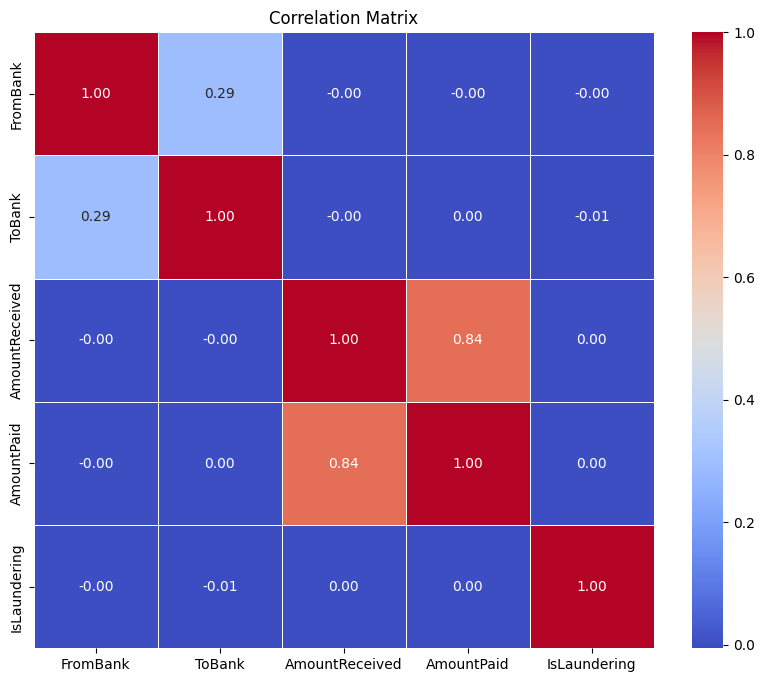

In [25]:
# Visualize the correlation matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming correlation_array contains the correlation matrix values

# Create a DataFrame from the correlation matrix array
correlation_df = pd.DataFrame(correlation_array, columns=feature_columns, index=feature_columns)

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


## Feature Engineering

### Feature Transformation

In [26]:
# Use StringIndexer to convert categorical columns to numerical
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index").fit(df) for col in ["ReceivingCurrency", "PaymentCurrency", "PaymentFormat"]]
pipeline = Pipeline(stages=indexers)
df_transformed = pipeline.fit(df).transform(df)

# Drop original categorical columns
df_transformed = df_transformed.drop("FromAccount", "ToAccount", "ReceivingCurrency", "PaymentCurrency", "PaymentFormat")

### Create Features Vector

In [27]:
from pyspark.ml.feature import VectorAssembler

# Define feature columns
feature_columns = df_transformed.columns[3:-1]  # Exclude Timestamp and IsLaundering

# Create a vector assembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform the DataFrame
df_assembled = assembler.transform(df_transformed)

In [28]:
#df_transformed.drop('FromBank','ToBank')
feature_columns

['AmountReceived',
 'AmountPaid',
 'IsLaundering',
 'ReceivingCurrency_index',
 'PaymentCurrency_index']

## Model Training

### Split Data into Training and Testing Sets

In [29]:
# Split the data into training and testing sets
(training_data, testing_data) = df_assembled.randomSplit([0.75, 0.25], seed=42)

### Train a Random Forest Classifier

In [30]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(labelCol="IsLaundering", featuresCol="features", numTrees=100)

# Train the model
model = rf.fit(training_data)

# Make predictions on the testing set
predictions = model.transform(testing_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="IsLaundering")
area_under_roc = evaluator.evaluate(predictions)
print(f"Area under ROC curve: {area_under_roc}")

Area under ROC curve: 1.0


## Model Evaluation and Interpretation

### Confusion Matrix

In [31]:
from sklearn.metrics import confusion_matrix

# Convert predictions to Pandas DataFrame for sklearn confusion matrix
predictions_pd = predictions.select("IsLaundering", "prediction").toPandas()
conf_matrix = confusion_matrix(predictions_pd["IsLaundering"], predictions_pd["prediction"])

print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[1269029       0]
 [      0    1302]]


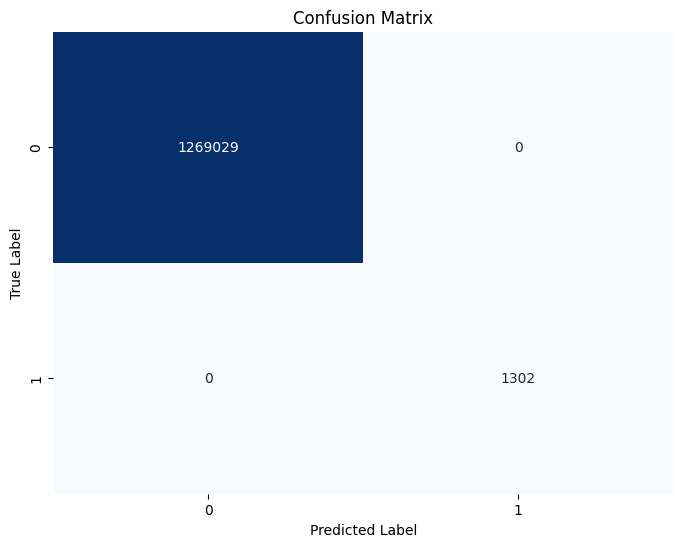

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have already calculated the confusion matrix
conf_matrix = confusion_matrix(predictions_pd["IsLaundering"], predictions_pd["prediction"])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Feature Importance

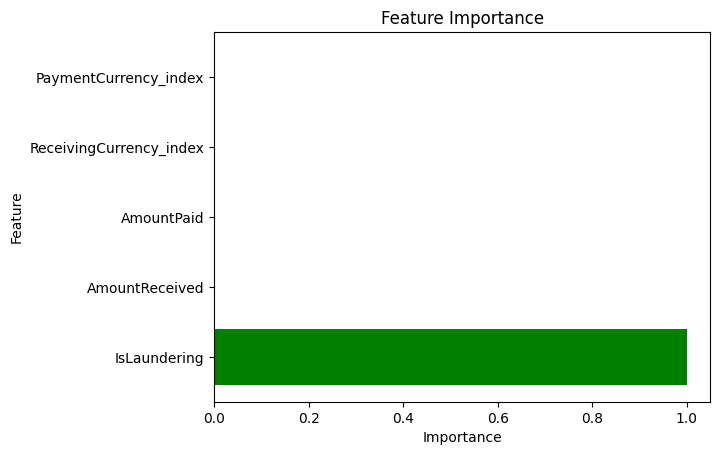

In [33]:
# Extract feature importances from the trained model
feature_importances = model.featureImportances.toArray()

# Create a Pandas DataFrame for better visualization
feature_importance_df = pd.DataFrame({"Feature": feature_columns, "Importance": feature_importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importances
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color='green')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


## Temporal Analysis

### Extract Temporal Features

In [34]:
# Extract temporal features from the timestamp column
df_temporal = df_assembled.withColumn("HourOfDay", hour("Timestamp"))
df_temporal = df_temporal.withColumn("DayOfWeek", dayofweek("Timestamp"))
df_temporal = df_temporal.withColumn("DayOfMonth", dayofmonth("Timestamp"))
df_temporal = df_temporal.withColumn("Month", month("Timestamp"))
df_temporal = df_temporal.withColumn("Year", year("Timestamp"))

### Explore Temporal Patterns

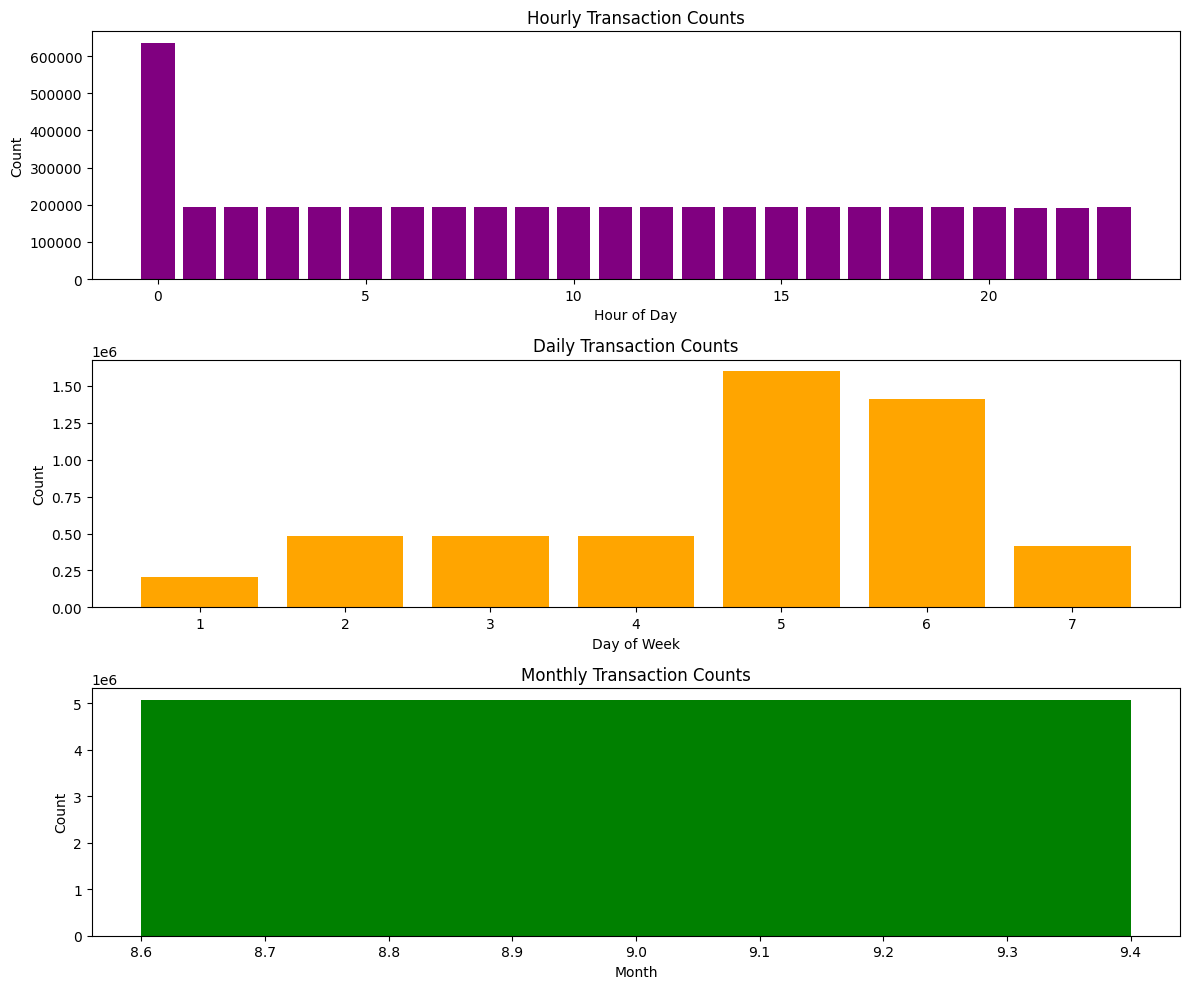

In [35]:
# Aggregate counts over different temporal features
hourly_counts = df_temporal.groupBy("HourOfDay").count().toPandas()
daily_counts = df_temporal.groupBy("DayOfWeek").count().toPandas()
monthly_counts = df_temporal.groupBy("Month").count().toPandas()

# Visualize temporal patterns
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

axes[0].bar(hourly_counts["HourOfDay"], hourly_counts["count"], color='purple')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Count')
axes[0].set_title('Hourly Transaction Counts')

axes[1].bar(daily_counts["DayOfWeek"], daily_counts["count"], color='orange')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Count')
axes[1].set_title('Daily Transaction Counts')

axes[2].bar(monthly_counts["Month"], monthly_counts["count"], color='green')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Count')
axes[2].set_title('Monthly Transaction Counts')

plt.tight_layout()
plt.show()


### Time Series Visualization

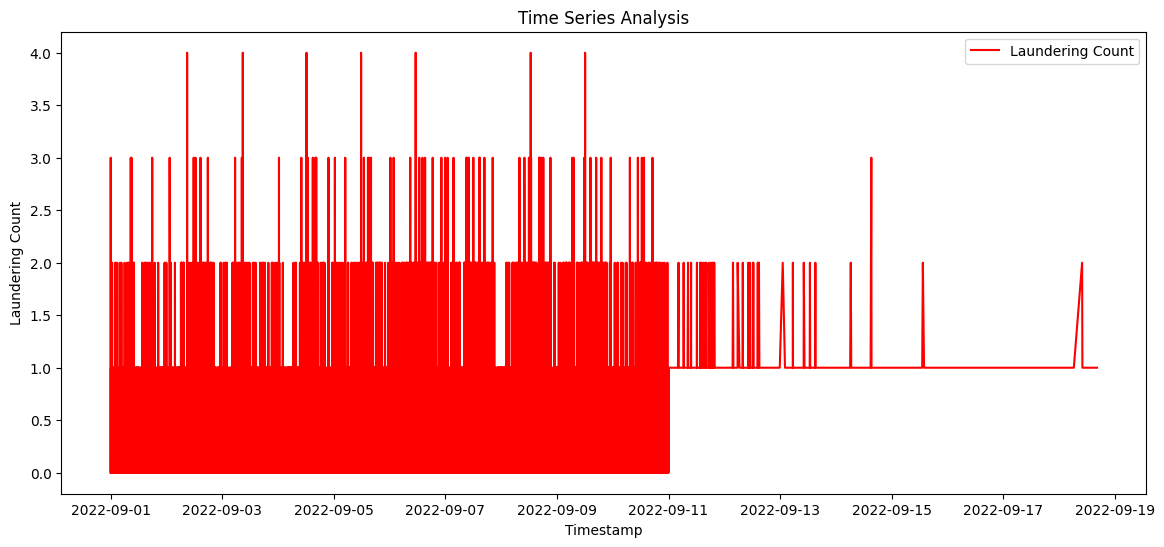

In [37]:
# Convert to Pandas DataFrame for plotting
time_series_pd = time_series_data.toPandas()

# Plot time series data
plt.figure(figsize=(14, 6))
plt.plot(time_series_pd["Timestamp"], time_series_pd["LaunderingCount"], label='Laundering Count', color='red')
plt.xlabel('Timestamp')
plt.ylabel('Laundering Count')
plt.title('Time Series Analysis')
plt.legend()
plt.show()

### Prepare Time Series Data

In [36]:
# Extract relevant columns for time series analysis
df_time_series = df_temporal.select("Timestamp", "IsLaundering")

# Group by timestamp and count the number of transactions
time_series_data = df_time_series.groupBy("Timestamp").agg(F.sum("IsLaundering").alias("LaunderingCount")).orderBy("Timestamp")

### CrossValidator for hyperparameter tuning of a Gradient Boosted Trees model and visualizing the results in the context of the original fraud detection code:

In [38]:
(train_df, test_df) = df_assembled.randomSplit([0.8, 0.2])

In [41]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder

gbt = GBTClassifier(labelCol="IsLaundering") 

paramGrid = ParamGridBuilder().addGrid(gbt.maxIter, [10, 50, 100]).addGrid(gbt.maxDepth, [2, 4, 6]).build()

In [42]:
from pyspark.ml.tuning import CrossValidator
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid, 
                          numFolds=5)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(metricName="accuracy", labelCol="IsLaundering")

crossval = CrossValidator(estimator=gbt, 
                          estimatorParamMaps=paramGrid,  
                          evaluator=evaluator,
                          numFolds=5)

cvModel = crossval.fit(train_df)
bestModel = cvModel.bestModel

In [ ]:
print(bestModel)

In [ ]:
# Save model
with open('xgb_model.pkl', 'wb') as file:  
    pickle.dump(model, file)

In [ ]:
# Make predictions on test data
predictions = bestModel.transform(test_df)

# Import evaluation metrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Accuracy
acc_evaluator = MulticlassClassificationEvaluator()
accuracy = acc_evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

# AUC 
auc_evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
auc = auc_evaluator.evaluate(predictions)
print("AUC:", auc)  

# F1 Score
f1_evaluator = MulticlassClassificationEvaluator(metricName="f1")
f1 = f1_evaluator.evaluate(predictions)
print("F1 Score:", f1)

# Confusion matrix
y_true = predictions.select("IsLaundering").collect()
y_pred = predictions.select("prediction").collect()

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred) 
print("Confusion Matrix: \n", cm)

In [ ]:
import matplotlib.pyplot as plt

df = cvModel.avgMetrics

plt.plot(df['maxDepth'], df['accuracy'], marker='o')
plt.xlabel('maxDepth')
plt.ylabel('Accuracy')
plt.title('GBT Classifier Tuning')

plt.show()

In [ ]:
# Load model
with open('xgb_model.pkl', 'rb') as file:
    model = pickle.load(file)
    
# Make prediction    
y_pred = model.predict(X_test)